# Automatic Hand Tracking - Veronica Zhao

In [ ]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 19.8 MB/s eta 0:00:00


In [ ]:
pip install segment_anything

# Part 1: Detect Hands in the First Frame

In [21]:
import mediapipe as mp
import cv2
import numpy as np
from typing import Dict, List, Tuple
import torch
from tqdm import tqdm
from mobile_sam import sam_model_registry, SamPredictor

In [ ]:
def detect_hands(image: np.ndarray) -> List[Dict[str, np.ndarray]]:
    """
    Detect hands in an image and return SAM2-compatible prompts.
    Returns list of dictionaries containing bounding boxes and points for prompts.
    """
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=4,
        min_detection_confidence=0.5
    )

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    hand_data = []
    if results.multi_hand_landmarks:
        height, width = image.shape[:2]

        for landmarks in results.multi_hand_landmarks:
            x_coords = [lm.x * width for lm in landmarks.landmark]
            y_coords = [lm.y * height for lm in landmarks.landmark]

            bbox = np.array([
                min(x_coords), min(y_coords),
                max(x_coords), max(y_coords)
            ]).astype(int)

            points = []
            key_indices = [0, 4, 8, 12, 16, 20]
            for idx in key_indices:
                point = np.array([
                    landmarks.landmark[idx].x * width,
                    landmarks.landmark[idx].y * height
                ]).astype(int)
                points.append(point)

            hand_data.append({
                'bbox': bbox,
                'points': np.array(points)
            })

    hands.close()
    return hand_data

if __name__ == "__main__":
    # read video first frame, already uploaded under content
    cap = cv2.VideoCapture('/content/test.mp4')
    ret, frame = cap.read()
    cap.release()

    if ret:
        hand_data = detect_hands(frame)

        vis_frame = frame.copy()
        for hand in hand_data:
            x1, y1, x2, y2 = hand['bbox']
            cv2.rectangle(vis_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            for point in hand['points']:
                cv2.circle(vis_frame, tuple(point), 5, (255, 0, 0), -1)

        cv2.imwrite('hand_detection.jpg', vis_frame)

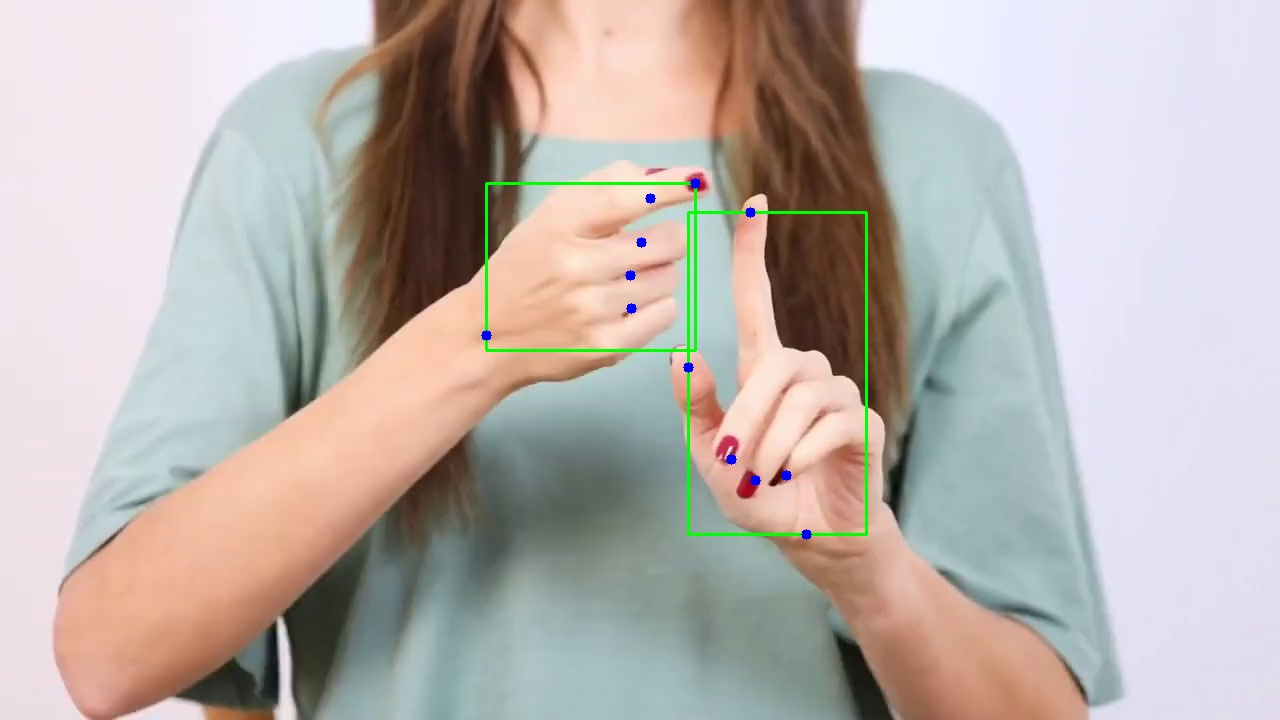

# Part 2: Use Part 1 and SAM 2 to Track Hands

In [17]:
pip install git+https://github.com/ChaoningZhang/MobileSAM.git

  Cloning https://github.com/ChaoningZhang/MobileSAM.git to /tmp/pip-req-build-yw_ukxtz
  Running command git clone --filter=blob:none --quiet https://github.com/ChaoningZhang/MobileSAM.git /tmp/pip-req-build-yw_ukxtz
  Resolved https://github.com/ChaoningZhang/MobileSAM.git to commit 34bbbfdface3c18e5221aa7de6032d7220c6c6a1
  Preparing metadata (setup.py) ... done
  Created wheel for mobile_sam: filename=mobile_sam-1.0-py3-none-any.whl size=42430 sha256=4942673b846dfbba00855e83212c13923a37083c4255d70b0edf04f2fbd28b5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-llsxpywu/wheels/5d/01/6d/a543d453fc9219c815786de44929ed1faa7bf6c8121e481cd7
Successfully built mobile_sam


In [19]:
!wget https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt

--2025-01-26 20:17:17--  https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40728226 (39M) [application/octet-stream]
Saving to: ‘mobile_sam.pt’

mobile_sam.pt       100%[===================>]  38.84M   193MB/s    in 0.2s    

2025-01-26 20:17:18 (193 MB/s) - ‘mobile_sam.pt’ saved [40728226/40728226]



In [20]:
def detect_hands(image: np.ndarray) -> List[Dict[str, np.ndarray]]:
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=4,
        min_detection_confidence=0.5
    )

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    hand_data = []
    if results.multi_hand_landmarks:
        height, width = image.shape[:2]

        for landmarks in results.multi_hand_landmarks:
            x_coords = [lm.x * width for lm in landmarks.landmark]
            y_coords = [lm.y * height for lm in landmarks.landmark]

            bbox = np.array([
                min(x_coords), min(y_coords),
                max(x_coords), max(y_coords)
            ]).astype(int)

            points = []
            key_indices = [0, 4, 8, 12, 16, 20]
            for idx in key_indices:
                point = np.array([
                    landmarks.landmark[idx].x * width,
                    landmarks.landmark[idx].y * height
                ]).astype(int)
                points.append(point)

            hand_data.append({
                'bbox': bbox,
                'points': np.array(points)
            })

    hands.close()
    return hand_data

def track_hands(input_path: str, output_path: str, sam_checkpoint: str = 'mobile_sam.pt') -> None:
    sam = sam_model_registry.get("vit_t")(checkpoint=sam_checkpoint)
    sam.to("cuda" if torch.cuda.is_available() else "cpu")
    predictor = SamPredictor(sam)

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    out = cv2.VideoWriter(output_path,
                         cv2.VideoWriter_fourcc(*'mp4v'),
                         fps, (width, height))

    with tqdm(total=total_frames) as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            hand_data = detect_hands(frame)

            if hand_data:
                predictor.set_image(frame)
                combined_mask = np.zeros((height, width), dtype=bool)

                for hand in hand_data:
                    points = hand['points']
                    point_labels = np.ones(len(points))

                    masks, scores, _ = predictor.predict(
                        point_coords=points,
                        point_labels=point_labels,
                        box=hand['bbox'][None, :],
                        multimask_output=False
                    )

                    combined_mask |= masks[0]

                frame[combined_mask] = frame[combined_mask] * 0.7 + np.array([0, 255, 0]) * 0.3

            out.write(frame)
            pbar.update(1)

    cap.release()
    out.release()

if __name__ == "__main__":
    track_hands('test.mp4', 'output.mp4')

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.11/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m